In [1]:
# importamos las librerías que necesitamos

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
# ------------------------------------------------------------------------------
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames
pd.set_option('display.float_format', '{:.2f}'.format)
# Gestión de los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

C:\Users\karin\AppData\Local\Temp\ipykernel_10584\4198490020.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Pair programming A/B testing
### Ejericicios de A/B Testing

**Ejercicio 1:**
Supongamos que estamos realizando un experimento para determinar si un nuevo diseño de anuncio (test group "ad") tiene un impacto significativo en la tasa de conversión en comparación con el diseño de anuncio anterior (test group "psa").

Objetivo del ejercicio: Comparar las tasas de conversión entre los grupos de prueba "ad" y "psa" para determinar si el nuevo diseño de anuncio es más efectivo en la conversión de usuarios.

Pasos que debemos seguir:

Preparación de los datos: Asegúrate de que los datos estén limpios y listos para el análisis. Esto incluye la eliminación de datos faltantes y la verificación de la coherencia de los datos.

Cálculo de la tasa de conversión: Calcula la tasa de conversión para cada grupo:

Para el grupo "ad", la tasa de conversión es el número de usuarios convertidos dividido por el número total de usuarios en ese grupo.

Para el grupo "psa", realiza el mismo cálculo.

Prueba de hipótesis: Utiliza una prueba estadística, como la prueba t de Student o la prueba chi-cuadrado, para comparar las tasas de conversión entre los grupos "ad" y "psa".

Análisis de resultados:

Si el valor p es menor que un umbral predefinido (por ejemplo, 0.05), rechazamos la hipótesis nula y concluimos que hay una diferencia significativa en las tasas de conversión entre los grupos.

Si el valor p es mayor que el umbral, no podemos rechazar la hipótesis nula y concluimos que no hay evidencia suficiente para afirmar que hay una diferencia significativa.

Conclusiones y recomendaciones: Basándote en los resultados de la prueba de hipótesis, llega a una conclusión sobre si el nuevo diseño de anuncio es más efectivo en la conversión de usuarios que el diseño anterior. Si es así, puedes hacer recomendaciones basadas en estos hallazgos.


In [2]:
# Exploramos el data frame 
df_marketing = pd.read_csv("files/marketing_AB.csv",index_col=0)
df_marketing.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [3]:
# Comprobamos de la columna test group sus grupos (PSA Y AD) y hacemos un value_counts() para ver sus resultados por cada grupo
df_marketing["test group"].value_counts()


test group
ad     564577
psa     23524
Name: count, dtype: int64

In [4]:
# Cambiamos el tipo de dato de la columna converted
df_marketing["converted"] = df_marketing["converted"].astype(int) 
# A continuación vemos con value_counts sus grupos y resultados por cada grupo 
df_marketing["converted"].value_counts()

converted
0    573258
1     14843
Name: count, dtype: int64

In [5]:
# Corregimos los títulos de las columnas, cambiando espacios por "_"
columnas = [col.replace(" ", "_") for col in df_marketing.columns]
df_marketing.columns = columnas

In [6]:
# A continuación, vamos a explorar el dataframe 
def exploracion_dataframe(dataframe, columna_control):
    """
    Realiza un análisis exploratorio básico de un DataFrame, mostrando información sobre duplicados,
    valores nulos, tipos de datos, valores únicos para columnas categóricas y estadísticas descriptivas
    para columnas categóricas y numéricas, agrupadas por la columna de control.

    Parámetros:
    - dataframe (DataFrame): El DataFrame que se va a explorar.
    - columna_control (str): El nombre de la columna que se utilizará como control para dividir el DataFrame.

    Returns: 
    No devuelve nada directamente, pero imprime en la consola la información exploratoria.
    """
    
    print(f"Los duplicados que tenemos en el conjunto de datos son: {dataframe.duplicated().sum()}")
    print("\n ..................... \n")
    
    
    # generamos un DataFrame para los valores nulos
    print("Los nulos que tenemos en el conjunto de datos son:")
    df_nulos = pd.DataFrame(dataframe.isnull().sum() / dataframe.shape[0] * 100, columns = ["%_nulos"])
    display(df_nulos[df_nulos["%_nulos"] > 0])
    
    print("\n ..................... \n")
    print(f"Los tipos de las columnas son:")
    display(pd.DataFrame(dataframe.dtypes, columns = ["tipo_dato"]))
    
    
    print("\n ..................... \n")
    print("Los valores que tenemos para las columnas categóricas son: ")
    dataframe_categoricas = dataframe.select_dtypes(include = "O")
    
    for col in dataframe_categoricas.columns:
        print(f"La columna {col} tiene las siguientes valore únicos:")
        display(pd.DataFrame(dataframe[col].value_counts()).head())    
    
    # como estamos en un problema de A/B testing y lo que realmente nos importa es comparar entre el grupo de control y el de test, los principales estadísticos los vamos a sacar de cada una de las categorías
    
    for categoria in dataframe[columna_control].unique():
        
        dataframe_filtrado = dataframe[dataframe[columna_control] == categoria]
    
        print("\n ..................... \n")
        print(f"Los principales estadísticos de las columnas categóricas para el {categoria} son: ")
        display(dataframe_filtrado.describe(include = "O").T)
        
        print("\n ..................... \n")
        print(f"Los principales estadísticos de las columnas numéricas para el {categoria} son: ")
        display(dataframe_filtrado.describe().T)

In [7]:
exploracion_dataframe(df_marketing,"test_group")

Los duplicados que tenemos en el conjunto de datos son: 0

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
user_id,int64
test_group,object
converted,int32
total_ads,int64
most_ads_day,object
most_ads_hour,int64



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna test_group tiene las siguientes valore únicos:


,count
test_group,
ad,564577
psa,23524


La columna most_ads_day tiene las siguientes valore únicos:


,count
most_ads_day,
Friday,92608
Monday,87073
Sunday,85391
Thursday,82982
Saturday,81660



 ..................... 

Los principales estadísticos de las columnas categóricas para el ad son: 


,count,unique,top,freq
test_group,564577,1,ad,564577
most_ads_day,564577,7,Friday,88805



 ..................... 

Los principales estadísticos de las columnas numéricas para el ad son: 


,count,mean,std,min,25%,50%,75%,max
user_id,564577.00,1327314.30,188918.06,1000000.00,1163686.00,1327362.00,1490914.00,1654483.00
converted,564577.00,0.03,0.16,0.00,0.00,0.00,0.00,1.00
total_ads,564577.00,24.82,43.75,1.00,4.00,13.00,27.00,2065.00
most_ads_hour,564577.00,14.48,4.84,0.00,11.00,14.00,18.00,23.00



 ..................... 

Los principales estadísticos de las columnas categóricas para el psa son: 


,count,unique,top,freq
test_group,23524,1,psa,23524
most_ads_day,23524,7,Thursday,3905



 ..................... 

Los principales estadísticos de las columnas numéricas para el psa son: 


,count,mean,std,min,25%,50%,75%,max
user_id,23524.00,911761.50,6790.94,900000.00,905880.75,911761.50,917642.25,923523.00
converted,23524.00,0.02,0.13,0.00,0.00,0.00,0.00,1.00
total_ads,23524.00,24.76,42.86,1.00,4.00,12.00,26.00,907.00
most_ads_hour,23524.00,14.30,4.66,0.00,11.00,14.00,18.00,23.00


Hipótesis nula (H0): No hay diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".

Hipótesis alternativa (H1): Existe una diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".

Cálculo de la tasa de conversión: Calcula la tasa de conversión para cada grupo:

Para el grupo "ad", la tasa de conversión es el número de usuarios convertidos dividido por el número total de usuarios en ese grupo.

Para el grupo "psa", realiza el mismo cálculo.

In [8]:
# Agrupamos por la columna test group y lo unimos con used_id y vemos su estructura
usuarios_totales = df_marketing.groupby("test_group")["user_id"].size()
print(f"Los usuarios totales son:\n {usuarios_totales}")

Los usuarios totales son:
 test_group
ad     564577
psa     23524
Name: user_id, dtype: int64


In [9]:
# Creamos una tabla de contingencia para analizar la relación entre las variables 'test_group' y 'converted'
contingency_table = pd.crosstab(df_marketing['test_group'], df_marketing['converted'])

# Realizamos el test de chi-cuadrado de independencia para determinar si hay una relación significativa entre las variables
# 'test_group' y 'converted'
chi2, p_chi2, _, _ = chi2_contingency(contingency_table)

# Visualizamos la tabla de contigencias 
contingency_table.head()

converted,0,1
test_group,,
ad,550154,14423
psa,23104,420


### Grupo "AD" - TASA DE CONVERSIÓN 

In [10]:
# Clasificamos por el grupo especifico de la columna test group 
df_ad = df_marketing[df_marketing['test_group'] == 'ad']
# Exploramos el nuevo data frame 
df_ad.head()

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,0,130,Monday,20
1,1119715,ad,0,93,Tuesday,22
2,1144181,ad,0,21,Tuesday,18
3,1435133,ad,0,355,Tuesday,10
4,1015700,ad,0,276,Friday,14


In [11]:
# Comprobamos el número de datos que contiene (filas)
total_usuarios = len(df_ad) 
print(f"El número total de usuarios es: {total_usuarios}")

El número total de usuarios es: 564577


In [12]:
# Comprobamos el número de datos que contiene (filas)
usuarios_convertidos = df_ad["converted"].sum()
print(f"El número total de usuarios convertidos es: {usuarios_convertidos}")

El número total de usuarios convertidos es: 14423


In [13]:
# Calculamos la conversión 
conversion = usuarios_convertidos / total_usuarios
print(f"El resultado de la conversióne es: {conversion}")

El resultado de la conversióne es: 0.025546559636683747


### Grupo "PSA" - TASA DE CONVERSIÓN 

In [14]:
# Creamos un nuevo data frame con la clasificación del grupo PSA de la columna test group 
df_psa = df_marketing[df_marketing["test_group"]== "psa"]
# Vemos el total de usuario del grupo 
total_usuarios_psa = len(df_psa) 
print(f"El número total de usuarios es: {total_usuarios_psa}")

El número total de usuarios es: 23524


In [15]:
# Comprobamos el número de datos que contiene (filas)
usuarios_convertidos_psa = df_psa["converted"].sum()
print(f"El número total de usuarios convertidos es: {usuarios_convertidos_psa}")

El número total de usuarios convertidos es: 420


In [16]:
# Calculamos la conversión
conversion_psa = usuarios_convertidos_psa / total_usuarios_psa
print(f"El resultado de la conversióne es: {conversion_psa}")

El resultado de la conversióne es: 0.01785410644448223


In [17]:
# Visualizamos ambas conversiones de forma correcta y legible 
display(conversion_psa,conversion)

0.01785410644448223

0.025546559636683747

In [18]:
print(contingency_table)

converted        0      1
test_group               
ad          550154  14423
psa          23104    420


- p_value < 0.05 rechazamos H0, concluimos que hay una diferencia significativa en las tasas de conversión entre los grupos. 
- p_value > 0.05 no podemos rechazar la hipótesis nula y concluimos que no hay evidencia suficiente para afirmar que hay una diferencia significativa.


**Ejercicio 2:**
En este caso, vamos a realizar un experimento para comparar la cantidad promedio de anuncios vistos por los usuarios en los grupos "ad" y "psa" y determinar si hay una diferencia significativa entre ellos.

Objetivo del experimento: Comparar la cantidad promedio de anuncios vistos por usuario entre los grupos de prueba "ad" y "psa" para determinar si el tipo de anuncio afecta la cantidad de anuncios que los usuarios ven.

Preparación de los datos: Asegúrate de que los datos estén limpios y listos para el análisis. Esto incluye la eliminación de datos faltantes y la verificación de la coherencia de los datos.

Hipótesis: Plantea una hipótesis nula (H0) y una hipótesis alternativa (H1) para el experimento. En este caso, las deberéis plantear vosotras

Prueba de hipótesis: Utiliza una prueba estadística, como la prueba t de Student, para comparar la cantidad promedio de anuncios vistos por usuario entre los grupos "ad" y "psa". Esto te permitirá determinar si hay una diferencia significativa entre los dos grupos.

Análisis de resultados:

Si el valor p (p-value) es menor que un umbral predefinido (por ejemplo, 0.05), rechazamos la hipótesis nula y concluimos que hay una diferencia significativa en la cantidad promedio de anuncios vistos por usuario entre los grupos.

Si el valor p es mayor que el umbral, no podemos rechazar la hipótesis nula y concluimos que no hay evidencia suficiente para afirmar que hay una diferencia significativa.

Conclusiones y recomendaciones: Basándote en los resultados de la prueba de hipótesis, llega a una conclusión sobre si el tipo de anuncio (ad o psa) tiene un impacto significativo en la cantidad promedio de anuncios vistos por usuario. Si es así, puedes hacer recomendaciones basadas en estos hallazgos.

Hipótesis:

- Hipótesis nula (H0): No hay diferencia significativa en la cantidad promedio de anuncios vistos por usuario entre los grupos "ad" y "psa".

- Hipótesis alternativa (H1): Existe una diferencia significativa en la cantidad promedio de anuncios vistos por usuario entre los grupos "ad" y "psa".

In [19]:
# Visualizamos nuevamente el data frame 
df_marketing.head()

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,0,130,Monday,20
1,1119715,ad,0,93,Tuesday,22
2,1144181,ad,0,21,Tuesday,18
3,1435133,ad,0,355,Tuesday,10
4,1015700,ad,0,276,Friday,14


No hay evidencia de una diferencia significativa en las tasas de anuncios vistos entre los grupos.

 ---------- 


          Los resultados sugieren que no existe evidencia estadística para afirmar que las medias de las muestras son distintas. 
          Por lo tanto, el análisis estadístico nos sugiere que estas diferencias no son significativas.
          


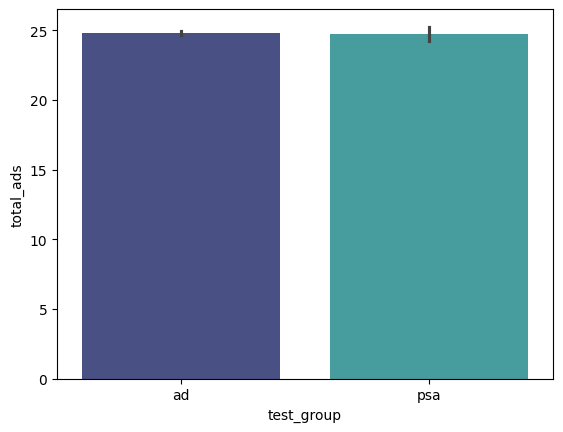

In [28]:
# Al igual que en el ejemplo principal, dividimos los datos en grupos de control y prueba
total_ads_ad = df_marketing[df_marketing["test_group"] == "ad"]["total_ads"]
total_ads_psa = df_marketing[df_marketing["test_group"] == "psa"]["total_ads"]


# antes de hacer la prueba estadística vemos si visualmente vemos diferencias entre los grupos
sns.barplot(x="test_group", y="total_ads", data=df_marketing, hue="test_group", palette="mako");

# Utilizando el método 'ttest_ind', evaluamos si los dos grupos son diferentes
t_statistic, p_value = ttest_ind(total_ads_ad, total_ads_psa)

# Imprimir el resultado de la prueba
if p_value < 0.05:
    print("Hay una diferencia significativa en las tasas de anuncios vistos entre el grupo de control y el grupo de prueba.")
    print("\n ---------- \n")
    print("""
          Los resultados sugieren que existe evidencia estadística para afirmar que las medias de las muestras son distintas. 
          Por lo tanto, nuestro nuevo sistema tiene los efectos deseados y deberíamos cambiar la nueva versión de anuncios.   
          """)
else:
    print("No hay evidencia de una diferencia significativa en las tasas de anuncios vistos entre los grupos.")
    print("\n ---------- \n")
    print("""
          Los resultados sugieren que no existe evidencia estadística para afirmar que las medias de las muestras son distintas. 
          Por lo tanto, el análisis estadístico nos sugiere que estas diferencias no son significativas.
          """)
